In [1]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### data reader

In [2]:
data_dict, int_label_pos_map = load_data_dict(
    mat_path, patients_list, phase_labels, param_keys_list
)

## First exploration: Distance of distances for a single patient across phases
Select a `patient`, then compute for each one the correlation matrix $C_{ij}^{\rm phase}$ per phase.
Here the objective is to define an order parameter that can measure the persistance of multiscale structure across phases.
Given the LRG induced ultrametric distances 
$$
    \mathcal{D}_{ij}(\tau) = \frac{1 - \delta_{ij}}{K_{ij}(\tau)},
$$
between the nodes in the network built in a time window, one can measure the (Euclidean) distance of distances
$$
    d(\mathcal{D}_{ij}^{t_1}(\tau), \mathcal{D}_{ij}^{t_2}(\tau))
$$
Maybe we want to consider the integral of this quantity ($\int d(\tau)\mathop{\rm d\tau}$) and maybe weight it on the relevant scales of the system.

The parameter can be used to measure the distance between rsPre and all the other phases (to see whether there is the strong persistance), or among all series (to see whether there is the weak persistance).

<span style="color:red">ATTENTION:</span> it might be that the distanc eis not weighting well all the scales cause small distances at smaller scale. At each scale one should weight!


In [3]:
patient = 'Pat_03'
#
data_pat = data_dict[patient]
pin_labels = int_label_pos_map[patient]['label']
#
correlation_protocol = dict(threshold=0,spectral_cleaning=False)
#
path_figs = Path('data') / 'figures' / 'per_patient_preVSpost'
path_figs.mkdir(parents=True, exist_ok=True)
# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=True)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='top')

### single case

In [4]:
ultrametric_distances = {}
linkage_matrices = {}
cond_dist_matrices = {}
for phase in phase_labels:
    print(phase)
    ultrametric_distances[phase] = {}
    linkage_matrices[phase] = {}
    cond_dist_matrices[phase] = {}
    data_pat_phase = data_pat[phase]
    data_pat_phase_ts = data_pat_phase['data']
    fs = data_pat_phase['fs']
    for band, (low_freq, high_freq) in BRAIN_BANDS.items():
        print(band)
        G, label_dict, lnkgM, clTh, corr_mat, dists = process_network_for_phase(data_pat_phase_ts, fs, band, correlation_protocol, pin_labels)
        ultrametric_distances[phase][band] = extract_ultrametric_matrix(lnkgM,G.number_of_nodes())
        linkage_matrices[phase][band] = lnkgM
        cond_dist_matrices[phase][band] = dists


rsPre
delta


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0068 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


theta


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0078 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


alpha


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0098 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


beta
low_gamma
low_gamma
high_gamma
high_gamma
taskLearn
delta
taskLearn
delta
theta
theta
alpha
alpha
beta
beta
low_gamma
low_gamma
high_gamma
high_gamma
taskTest
delta
taskTest
delta
theta
theta
alpha
alpha
beta
beta
low_gamma
low_gamma
high_gamma
high_gamma
rsPost
delta
rsPost
delta
theta
theta
alpha
alpha
beta
beta
low_gamma
low_gamma
high_gamma
high_gamma


### Computing the Distance between Ultrametric Distances: Mathematical Framework

The computation of distances between ultrametric distance matrices is a sophisticated procedure that requires careful handling of hierarchical structures and permutation invariance. This section provides a detailed mathematical description of the implemented algorithm.

#### Step 1: Hierarchical Clustering and Linkage Matrices

For each experimental phase $\phi \in \{\text{rsPre}, \text{taskLearn}, \text{taskTest}, \text{rsPost}\}$ and frequency band $\beta$ (e.g., delta, theta, alpha, beta, gamma), we compute:

1. **Correlation Matrix**: From the EEG time series data $X_{\phi,\beta}(t)$ with $N$ electrodes, we compute the Pearson correlation matrix:
   $$C_{ij}^{\phi,\beta} = \frac{\text{cov}(X_i^{\phi,\beta}, X_j^{\phi,\beta})}{\sigma_i^{\phi,\beta} \sigma_j^{\phi,\beta}}$$

2. **Distance Matrix**: Convert correlations to distances:
   $$D_{ij}^{\phi,\beta} = \sqrt{2(1 - C_{ij}^{\phi,\beta})}$$

3. **Linkage Matrix**: Apply hierarchical clustering (e.g., Ward's method) to obtain the linkage matrix $Z^{\phi,\beta}$ of shape $(N-1, 4)$, where each row $k$ contains:
   - Indices of clusters being merged: $Z_k[0], Z_k[1]$
   - Distance at which merger occurs: $Z_k[2]$
   - Number of nodes in new cluster: $Z_k[3]$

#### Step 2: Ultrametric Distance Matrix Construction

From the linkage matrix $Z^{\phi,\beta}$, we construct the **cophenetic (ultrametric) distance matrix** $\mathcal{U}^{\phi,\beta}$:

$$\mathcal{U}_{ij}^{\phi,\beta} = \text{height of lowest common ancestor of nodes } i \text{ and } j \text{ in the dendrogram}$$

This is computed using the cophenetic distance function:
```python
cophenetic_distances = cophenet(Z)  # condensed form
U = squareform(cophenetic_distances)  # full matrix
```

The ultrametric property ensures that for any three points $i, j, k$:
$$\mathcal{U}_{ij} \leq \max(\mathcal{U}_{ik}, \mathcal{U}_{jk})$$

#### Step 3: Permutation-Robust Distance Computation

The core challenge is computing meaningful distances between ultrametric matrices $\mathcal{U}^{\phi_1,\beta}$ and $\mathcal{U}^{\phi_2,\beta}$ that are **invariant to leaf permutations** in the dendrograms.

##### 3.1 Optimal Leaf Ordering (OLO)

For each phase, we compute an optimal leaf ordering that minimizes the sum of distances between adjacent leaves in the dendrogram:

$$\text{ord}^{\phi,\beta} = \arg\min_{\sigma} \sum_{i=1}^{N-1} D_{\sigma(i),\sigma(i+1)}^{\phi,\beta}$$

where $\sigma$ is a permutation of leaf indices and $D^{\phi,\beta}$ is the original distance matrix.

##### 3.2 Canonical Ordering Alignment

To ensure meaningful comparison, both ultrametric matrices are reindexed to a **canonical ordering**:

- **Option 1**: Use provided `canonical_labels` (e.g., electrode names) and sort: `canon_ord = argsort(canonical_labels)`
- **Option 2**: Use the OLO ordering of the first phase as canonical: `canon_ord = ord¹`

##### 3.3 Matrix Reindexing

Both ultrametric matrices are reindexed to the canonical order:
$$\mathcal{U}_{\text{reindexed}}^{\phi,\beta} = P_{\text{canon}} \cdot \mathcal{U}^{\phi,\beta} \cdot P_{\text{canon}}^T$$

where $P_{\text{canon}}$ is the permutation matrix corresponding to the canonical ordering.

#### Step 4: Distance Computation

Finally, we compute the Euclidean distance between the upper triangular parts of the reindexed ultrametric matrices:

1. **Extract upper triangular elements**:
   $$\mathbf{u}_1 = \text{upper_tri}(\mathcal{U}_{\text{reindexed}}^{\phi_1,\beta}), \quad \mathbf{u}_2 = \text{upper_tri}(\mathcal{U}_{\text{reindexed}}^{\phi_2,\beta})$$

2. **Compute distance**:
   $$d(\mathcal{U}^{\phi_1,\beta}, \mathcal{U}^{\phi_2,\beta}) = \|\mathbf{u}_1 - \mathbf{u}_2\|_2 = \sqrt{\sum_{i<j} (\mathcal{U}_{ij,\text{reindexed}}^{\phi_1,\beta} - \mathcal{U}_{ij,\text{reindexed}}^{\phi_2,\beta})^2}$$

#### Step 5: Distance Matrix Assembly

The final distance matrix $\mathbf{D}_{\text{phases}}$ for a given frequency band is constructed as:

$$\mathbf{D}_{\text{phases}}[i,j] = d(\mathcal{U}^{\phi_i,\beta}, \mathcal{U}^{\phi_j,\beta})$$

This matrix is symmetric with zeros on the diagonal and captures the **persistence of multiscale hierarchical structure** across experimental phases.

#### Interpretation

- **Small distances**: Phases with similar hierarchical organization of brain connectivity
- **Large distances**: Phases with substantially different multiscale network structures
- **Persistence analysis**: Evolution of network hierarchy across experimental conditions

The method is robust to:
- Arbitrary leaf permutations in dendrograms
- Different clustering algorithms (as long as linkage format is consistent)
- Various distance metrics (Euclidean, cosine, correlation, etc.)

In [5]:
band = 'beta'
n = len(phase_labels)
distance_matrix = np.zeros((n, n))

for i, phase in enumerate(phase_labels):
    for j, phase2 in enumerate(phase_labels):
        if i < j:
            d = ultrametric_distance_permutation_robust(linkage_matrices[phase][band], linkage_matrices[phase2][band], cond_dist_matrices[phase][band], cond_dist_matrices[phase2][band], pin_labels, metric='euclidean')
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

# distance_matrix /= np.max(distance_matrix)

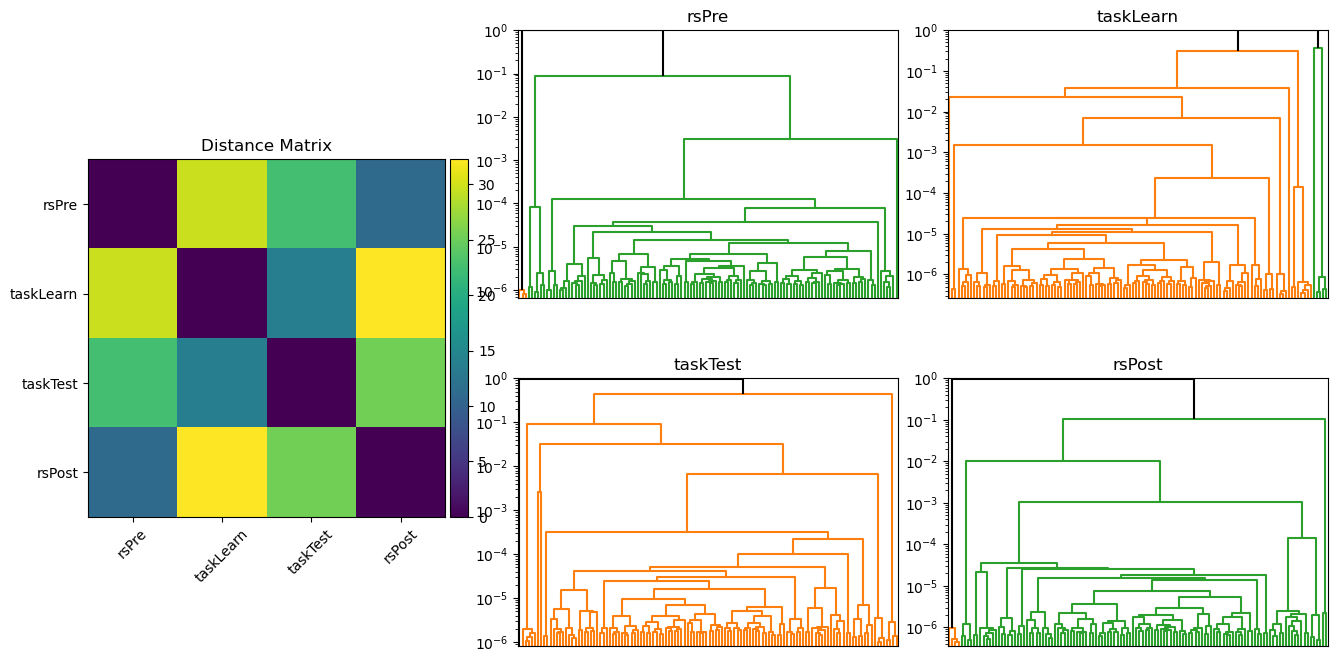

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import dendrogram, optimal_leaf_ordering

# Create figure with GridSpec for custom layout
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.3)

# Left subplot for distance matrix - now spans 2 columns instead of 1
ax_dist = fig.add_subplot(gs[:, 0:2])
im = ax_dist.imshow(distance_matrix, cmap='viridis')
ax_dist.set_title('Distance Matrix')
ax_dist.set_xticks(range(len(phase_labels)))
ax_dist.set_yticks(range(len(phase_labels)))
ax_dist.set_xticklabels(phase_labels, rotation=45)
ax_dist.set_yticklabels(phase_labels)
div, cax, clb = imshow_colorbar_caxdivider(im, ax_dist)
# plt.colorbar(im, ax=ax_dist)

# Right subplots for dendrograms (2x2 grid) - now starting from column 2
for i, phase in enumerate(phase_labels):
    row = i // 2
    col = i % 2 + 2  # Start from column 2 (after distance matrix)
    if col == 2:
        ax_dend = fig.add_subplot(gs[row, 2:4])  # Span 2 columns for first dendrogram in each row
    else:
        ax_dend = fig.add_subplot(gs[row, 4:6])  # Span 2 columns for second dendrogram in each row
    
    lnkg = linkage_matrices[phase][band]
    Z_opt = optimal_leaf_ordering(lnkg, cond_dist_matrices[phase][band])
    dendrogram(Z_opt, ax=ax_dend, no_labels=True, **kw_dentro)
    ax_dend.set_yscale('log')
    tmin = lnkg[:, 2][0] * 0.8
    tmax = lnkg[:, 2][-1] * 1.01
    ax_dend.set_ylim(tmin, tmax)
    ax_dend.set_title(f'{phase}')

plt.show()

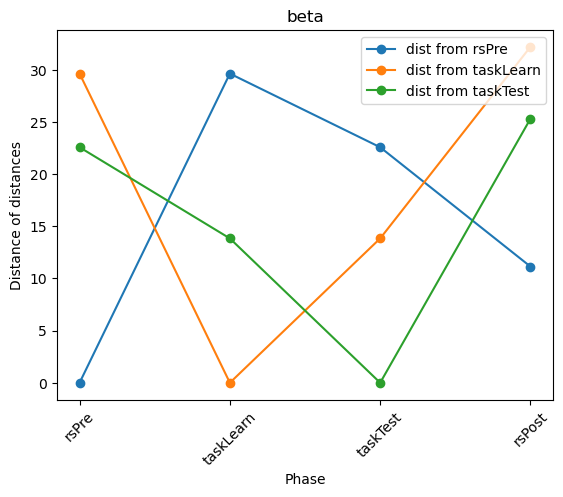

In [7]:
plt.plot(np.arange(4), distance_matrix[0], 'o-', label='dist from rsPre')
plt.plot(np.arange(4), distance_matrix[1], 'o-', label='dist from taskLearn')
plt.plot(np.arange(4), distance_matrix[2], 'o-', label='dist from taskTest')

plt.title(band)
plt.ylabel('Distance of distances')
plt.xlabel('Phase')
plt.legend()
plt.xticks(np.arange(4), phase_labels, rotation=45)
plt.savefig(path_figs / f'distance_of_distances_{patient}_{band}.png', bbox_inches='tight')
# plt.plot(np.arange(4), distance_matrix[2], 'o')